# Data

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
IMAGE_SIZE = [100, 100]
epochs = 5
batch_size = 32

train_path = 'fruits-360-small/Training'
valid_path = 'fruits-360-small/Validation'

In [3]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

print("Number of training images:", len(image_files))
print("Number of validation images: ", len(valid_image_files))
print("Number of classes: ", len(folders))

Number of training images: 3827
Number of validation images:  1285
Number of classes:  8


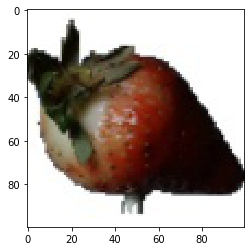

In [4]:
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

# Model

In [5]:
# Loading the model feature transformation layers and then adding the final linear layer using keras

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# we specify image size, weights and then we choose not to include top and hence cutting off the head of the model(output linear layer)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers(for specific output classes) - you can add more if you want
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

58892288/58889256 [==============================] - 31s 1us/step


In [6]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: &quot;model&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)   

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

# Data Generators

In [8]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

Found 1285 images belonging to 8 classes.
{&#39;Apple Golden 1&#39;: 0, &#39;Avocado&#39;: 1, &#39;Banana&#39;: 2, &#39;Kiwi&#39;: 3, &#39;Lemon&#39;: 4, &#39;Mango&#39;: 5, &#39;Raspberry&#39;: 6, &#39;Strawberry&#39;: 7}
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
min: -119.11905 max: 151.061


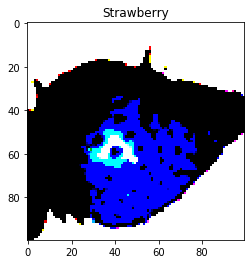

In [9]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR) - confirms that preprocessing worked
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [10]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3827 images belonging to 8 classes.
Found 1285 images belonging to 8 classes.


# Training

In [11]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
119/119 [==============================] - 89s 744ms/step - loss: 0.7753 - accuracy: 0.9433 - val_loss: 0.1034 - val_accuracy: 0.9852
Epoch 2/5
119/119 [==============================] - 17s 142ms/step - loss: 0.0538 - accuracy: 0.9931 - val_loss: 0.0549 - val_accuracy: 0.9937
Epoch 3/5
119/119 [==============================] - 17s 145ms/step - loss: 0.0193 - accuracy: 0.9974 - val_loss: 0.0105 - val_accuracy: 0.9984
Epoch 4/5
119/119 [==============================] - 18s 148ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0294 - val_accuracy: 0.9953
Epoch 5/5
119/119 [==============================] - 18s 152ms/step - loss: 0.0104 - accuracy: 0.9989 - val_loss: 0.0030 - val_accuracy: 0.9984


# Confusion Matrix and Plotting

There is one row and column for every class in the confusion matrix. Guide on how to read a confusion matrix - https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826#:~:text=A%20confusion%20matrix%20is%20a,the%20classes%20correctly%20or%20incorrectly

In [12]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [13]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)
# there is one row and column for every class in the confusion matrix

Generating confusion matrix 3827
Found 3827 images belonging to 8 classes.
50
[[480   0   0   0   0   0   0   0]
 [  0 425   0   0   0   2   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1285
Found 1285 images belonging to 8 classes.
[[160   0   0   0   0   0   0   0]
 [  0 142   0   0   0   1   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


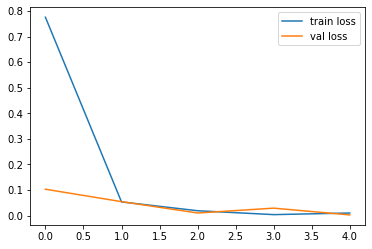

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

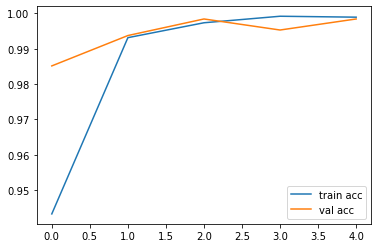

In [15]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()